# Parametrized DNN
parametrized DNN 
1. Plot signal and background seperation
2. Include all signals
2. check the backgrounds.
3. Check the AUC score as this is coming 1
4. Improve the training
5. include the weight of preselection

In [1]:
import os
import pandas as pd
import uproot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

# Taking mass X and corresponding Y mass points
# mass_points = [300, 400, 500, 550, 600, 650, 700, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2500, 3000, 3500, 4000]  # Example mass points
# y_values = [ 60, 70, 80, 90, 95, 100, 125, 150, 200, 300, 400, 500, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2600, 3000, 3500]  # Example Y values

mass_points = [300, 400, 500, 550, 600, 650, 700, 900, 1000]  # Example mass points
y_values = [ 100, 125, 150, 200, 300, 400, 500]  # Example Y values



# Load signal data from Parquet files
signal_data = []
for mass in mass_points:
    for y in y_values:
        file_path = f"../../../output_parquet/final_production_Syst/merged/NMSSM_X{mass}_Y{y}/nominal/NOTAG_merged.parquet"
        
        if os.path.exists(file_path):  # Check if file exists
            try:
                df = pd.read_parquet(file_path)  # Load the Parquet file
                df["mass"] = mass  
                df["y_value"] = y  # Store Y value if needed
                df["label"] = 1  # Assuming signal label
                signal_data.append(df)
            except Exception as e:
                print(f"Warning: Could not read {file_path}. Error: {e}")
        else:
            print(f"Warning: File {file_path} does not exist.")

# Combine all signal data into a single DataFrame
signal_df = pd.concat(signal_data, ignore_index=True) if signal_data else pd.DataFrame()

In [2]:
signal_df.shape

(346281, 853)

In [3]:
# Load background data from ROOT files
background_files = [
    ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GGJets/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GJetPt20To40/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GJetPt40/preselection"),
#     ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GGJets/preselection"),
#     ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GJetPt20To40/preselection"),
#     ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GJetPt40/preselection"),
]
background_data = []
for file_path, tree_name in background_files:
    try:
        with uproot.open(file_path) as file:
            tree = file[tree_name]
            df = tree.arrays(library="pd")
            df["mass"] = np.random.choice(mass_points, len(df))  # Random mass assignment
            df["label"] = 0
            background_data.append(df)
    except Exception as e:
        print(f"Warning: Could not read {file_path}. Error: {e}")

df_background = pd.concat(background_data, ignore_index=True) if background_data else pd.DataFrame()

In [4]:
# Define features and labels
features = [
    'bbgg_eta', 'bbgg_phi', 'lead_pho_phi', 'sublead_pho_eta', 
    'sublead_pho_phi', 'diphoton_eta', 'diphoton_phi', 'dibjet_eta', 'dibjet_phi', 
    'lead_bjet_pt', 'sublead_bjet_pt', 'lead_bjet_eta', 'lead_bjet_phi', 'sublead_bjet_eta', 
    'sublead_bjet_phi', 'sublead_bjet_PNetB', 'lead_bjet_PNetB', 'CosThetaStar_gg', 
    'CosThetaStar_jj', 'CosThetaStar_CS', 'DeltaR_jg_min', 'pholead_PtOverM', 
    'phosublead_PtOverM', 'lead_pho_mvaID', 'sublead_pho_mvaID'
]
features.extend(["mass", "y_value"])


In [5]:
features

['bbgg_eta',
 'bbgg_phi',
 'lead_pho_phi',
 'sublead_pho_eta',
 'sublead_pho_phi',
 'diphoton_eta',
 'diphoton_phi',
 'dibjet_eta',
 'dibjet_phi',
 'lead_bjet_pt',
 'sublead_bjet_pt',
 'lead_bjet_eta',
 'lead_bjet_phi',
 'sublead_bjet_eta',
 'sublead_bjet_phi',
 'sublead_bjet_PNetB',
 'lead_bjet_PNetB',
 'CosThetaStar_gg',
 'CosThetaStar_jj',
 'CosThetaStar_CS',
 'DeltaR_jg_min',
 'pholead_PtOverM',
 'phosublead_PtOverM',
 'lead_pho_mvaID',
 'sublead_pho_mvaID',
 'mass',
 'y_value']

In [6]:
# Random mass + y_value assignment for backgrounds (ensure this was done earlier!)
df_background["mass"] = np.random.choice(mass_points, len(df_background))
df_background["y_value"] = np.random.choice(y_values, len(df_background))


In [7]:

# Reduce background dataset size by random sampling
background_fraction = 0.5 #  20% of the background
df_background = df_background.sample(frac=background_fraction, random_state=42)

# Combine signal and background
df_combined = pd.concat([signal_df, df_background], ignore_index=True)

# Ensure df_combined is not empty
if df_combined.empty:
    raise ValueError("Error: Combined DataFrame is empty. Check input files.")

# Convert feature data to DataFrame to prevent AttributeError
df_features = df_combined[features]

# Fill missing values with column mean
df_features = df_features.fillna(df_features.mean())

# Extract features (X) and labels (y)
X = df_features.values
y = df_combined["label"].values

In [8]:
df_features.shape

(2011751, 27)

In [9]:
from sklearn.model_selection import train_test_split

# Split into 80% train, 20% test (stratified to maintain label distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features (Fit only on train, transform both)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)  

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create Dataloader for training
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Optional: Create test dataloader if you want batch evaluation
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [10]:
# Checking

print(signal_df["mass"].unique())
print(df_background["mass"].unique())


[ 300  400  500  550  600  650  700  900 1000]
[1000  300  900  700  500  550  650  600  400]


In [11]:
print(df_background.columns)


Index(['run', 'lumi', 'event', 'puppiMET_pt', 'puppiMET_phi',
       'puppiMET_phiJERDown', 'puppiMET_phiJERUp', 'puppiMET_phiJESDown',
       'puppiMET_phiJESUp', 'puppiMET_phiUnclusteredDown',
       'puppiMET_phiUnclusteredUp', 'puppiMET_ptJERDown', 'puppiMET_ptJERUp',
       'puppiMET_ptJESDown', 'puppiMET_ptJESUp', 'puppiMET_ptUnclusteredDown',
       'puppiMET_ptUnclusteredUp', 'puppiMET_sumEt', 'lead_pho_pt',
       'lead_pho_eta', 'lead_pho_phi', 'sublead_pho_pt', 'sublead_pho_eta',
       'sublead_pho_phi', 'lead_bjet_pt', 'lead_bjet_eta', 'lead_bjet_phi',
       'sublead_bjet_pt', 'sublead_bjet_eta', 'sublead_bjet_phi',
       'dibjet_mass', 'diphoton_mass', 'bbgg_mass', 'dibjet_pt', 'diphoton_pt',
       'bbgg_pt', 'bbgg_eta', 'bbgg_phi', 'weight_central',
       'weight_preselection', 'weight_selection', 'weight_srbbgg',
       'weight_srbbggMET', 'weight_crbbantigg', 'weight_crantibbgg',
       'weight_crantibbantigg', 'weight_sideband', 'weight_idmva_sideband',
       'we

In [12]:
print("Signal y_value:", signal_df["y_value"].unique())
print("Background y_value:", df_background["y_value"].unique())


Signal y_value: [100 125 150 200 300 400 500]
Background y_value: [300 500 400 125 200 150 100]


In [13]:
import torch
import torch.nn as nn
from torch.optim import Adam

class ParameterizedDNN(nn.Module):
    def __init__(self, input_dim):
        super(ParameterizedDNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),
            
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(0.3),

            nn.Linear(16, 1)
        )

#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 32),
#             nn.ReLU(),
#             nn.BatchNorm1d(32),  # Helps stabilize training
#             nn.Dropout(0.2),  # Reduce dropout

#             nn.Linear(32, 16),
#             nn.ReLU(),
#             nn.BatchNorm1d(16),
#             nn.Dropout(0.2),
            
#             nn.Linear(16, 8),
#             nn.ReLU(),
#             nn.BatchNorm1d(8),
#             nn.Dropout(0.1),  # Lower dropout to retain information
            
#             nn.Linear(8, 1)  # Output layer (raw logits)
#         )

    def forward(self, x):
        return self.model(x)




Text(0.5, 1.0, 'Mass Distribution')

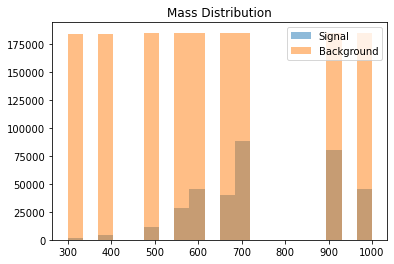

In [14]:
# Mass distribution
import matplotlib.pyplot as plt

plt.hist(signal_df['mass'], bins=20, alpha=0.5, label='Signal')
plt.hist(df_background['mass'], bins=20, alpha=0.5, label='Background')
plt.legend()
plt.title("Mass Distribution")


In [15]:
# class balance
print("signal shape", signal_df.shape, "background.shape", df_background.shape)


signal shape (346281, 853) background.shape (1665470, 92)


In [16]:
import torch
from torch.optim import Adam
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import os

# Initialize model
input_dim = X.shape[1]
model = ParameterizedDNN(input_dim)
criterion = nn.BCEWithLogitsLoss()  # Expecting raw logits
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training parameters
num_epochs = 50
patience = 5
best_auc = 0.0
patience_counter = 0
save_path = "best_parametric_model.pt"

train_losses, train_accuracies, train_aucs = [], [], []
fpr_all, tpr_all, thresholds_all = [], [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    y_true_train, y_pred_train = [], []

    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        y_true_train.extend(y_batch.cpu().numpy())
        y_pred_train.extend(torch.sigmoid(outputs).detach().cpu().numpy())

    y_pred_train_binary = [1 if p > 0.5 else 0 for p in y_pred_train]
    train_accuracy = accuracy_score(y_true_train, y_pred_train_binary)
    train_auc = roc_auc_score(y_true_train, y_pred_train)

    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_tensor.to(device)).squeeze()
        y_pred_test = torch.sigmoid(outputs_test).cpu().numpy()
        test_loss = criterion(outputs_test, y_test_tensor.to(device)).item()

        y_pred_test_binary = [1 if p > 0.5 else 0 for p in y_pred_test]
        test_accuracy = accuracy_score(y_test, y_pred_test_binary)
        test_auc = roc_auc_score(y_test, y_pred_test)

    train_losses.append(epoch_loss / len(train_dataloader))
    train_accuracies.append(train_accuracy)
    train_aucs.append(train_auc)

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracy:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Test  Loss: {test_loss:.4f} | Test  Acc: {test_accuracy:.4f} | Test  AUC: {test_auc:.4f}")

    # Early stopping based on test AUC
    if test_auc > best_auc:
        best_auc = test_auc
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"✅ Model improved. Saved to: {save_path}")
    else:
        patience_counter += 1
        print(f"No improvement in AUC for {patience_counter} epoch(s).")

    if patience_counter >= patience:
        print("⛔ Early stopping triggered.")
        break

# Load best model before proceeding
model.load_state_dict(torch.load(save_path))
print("✅ Best model loaded from checkpoint.")


KeyboardInterrupt: 

# Next step

- [ ] Implement early stopping
- [ ] Save the model
- [ ] get the dNN score
- [ ] Plot it like as in the approval of manos
- [ ] Can also plot the signal and background seperations
- [ ] Plot AUC
- [ ] AUC, ROC
- [ ] Signal and background separation
- [ ] Check all variables. Include all variables 	
- [ ] pNN transformed score
- [ ] Plot feature importance 







In [ ]:
## Debugging
interpolation_mass = 375  # between 300 and 400
interpolation_y = 175     # between 150 and 200

df_interp = df_background.sample(n=1000, random_state=42).copy()
df_interp["mass"] = interpolation_mass
df_interp["y_value"] = interpolation_y


In [ ]:
# 1. Choose an unseen MX, MY
interpolation_mass = 375
interpolation_y = 175

# 2. Sample and set new param values
df_interp = df_background.sample(n=1000, random_state=42).copy()
df_interp["mass"] = interpolation_mass
df_interp["y_value"] = interpolation_y

# 3. Use the same features and preprocessing
X_interp = df_interp[features].fillna(df_features.mean()).values
X_interp = scaler.transform(X_interp)  # same scaler as training
X_interp_tensor = torch.tensor(X_interp, dtype=torch.float32).to(device)

# 4. Get model output
model.eval()
with torch.no_grad():
    y_interp_pred = torch.sigmoid(model(X_interp_tensor)).cpu().numpy()

# 5. Plot output distribution
plt.hist(y_interp_pred, bins=50, alpha=0.7, label=f"Interpolated (MX={interpolation_mass}, MY={interpolation_y})")
plt.xlabel("DNN Score")
plt.title("pNN Output at Interpolated Mass Point")
plt.legend()
plt.show()


In [ ]:
# Feature importance(Error)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def compute_permutation_importance(model, X_val, y_val, mass_val, feature_names, device='cpu'):
    model.eval()
    X_val = X_val.clone().detach().to(device)
    mass_val = mass_val.clone().detach().to(device)
    y_val_np = y_val.cpu().numpy()

    base_preds = torch.sigmoid(model(X_val, mass_val).squeeze()).detach().cpu().numpy()
    base_auc = roc_auc_score(y_val_np, base_preds)

    importances = []

    for i in range(X_val.shape[1]):
        scores = []
        for _ in range(5):  # repeat for stability
            X_shuffled = X_val.clone()
            idx = torch.randperm(X_val.shape[0])
            X_shuffled[:, i] = X_shuffled[idx, i]
            preds = torch.sigmoid(model(X_shuffled, mass_val).squeeze()).detach().cpu().numpy()
            auc = roc_auc_score(y_val_np, preds)
            scores.append(base_auc - auc)  # performance drop
        importances.append(np.mean(scores))

    return np.array(importances)

# Call the function
importances = compute_permutation_importance(model, X_test_tensor, y_test_tensor, mass_test_tensor, feature_names, device=device)

# Plot
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 12))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
plt.xlabel("Permutation Importance (AUC drop)")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.title("Feature Importance (Permutation - Parametric DNN)")
plt.xscale('log')
plt.tight_layout()
plt.show()


In [ ]:
train_losses.append(epoch_loss / len(train_dataloader))
train_accuracies.append(train_accuracy)
train_aucs.append(train_auc)

# Add test AUC for plotting too
if epoch == num_epochs - 1:
    plt.plot(train_aucs, label='Train AUC')
    plt.axhline(test_auc, color='red', linestyle='--', label='Test AUC (final)')
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.title("Train vs. Test AUC")
    plt.show()


In [ ]:
plt.hist(y_pred_test[y_test == 1], bins=50, alpha=0.5, label='Signal')
plt.hist(y_pred_test[y_test == 0], bins=50, alpha=0.5, label='Background')
plt.legend()
plt.title("DNN Output Scores on Test Set")
plt.xlabel("Score")
plt.show()


In [ ]:
df_bkg = df_background.copy()
df_bkg["mass"] = 500
df_bkg["y_value"] = 200


In [ ]:
df_sig = signal_df[(signal_df['mass'] == 500) & (signal_df['y_value'] == 200)].copy()


In [ ]:
df_bkg = df_background.copy()
df_bkg["mass"] = 500
df_bkg["y_value"] = 200


In [ ]:
def preprocess(df, scaler, features, fallback_mean=None):
    df_features_local = df[features].copy()

    # Fallback to global mean if passed (e.g., from training data)
    if fallback_mean is not None:
        df_features_local = df_features_local.fillna(fallback_mean)
    else:
        df_features_local = df_features_local.fillna(df_features_local.mean())

    X = df_features_local.values
    X_scaled = scaler.transform(X)
    return torch.tensor(X_scaled, dtype=torch.float32).to(device)


In [ ]:
print(df_combined['label'].value_counts())


## Fixing

In [ ]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Combine signal and background into a single DataFrame
full_df = pd.concat([signal_df, df_background], ignore_index=True)

# Define train/test mass points
train_masses = [300, 500, 600, 700, 1000]
test_masses = [400, 550, 650, 900]

# Split by mass
train_df = full_df[full_df['mass'].isin(train_masses)]
test_df = full_df[full_df['mass'].isin(test_masses)]

# Shuffle rows
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Define your feature list (must match your actual feature engineering)
features = [col for col in train_df.columns if col not in ['label']]  # include 'mass' and 'y_value' if needed

# Prepare inputs and targets
X_train = train_df[features].fillna(0).values
y_train = train_df['label'].values
X_test = test_df[features].fillna(0).values
y_test = test_df['label'].values

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Wrap in datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
